In [32]:
# General
import numpy as np
import pickle as pk
import math

# For optimization
import pygmo as pg

# For computing acceleration and potential
import polyhedral_gravity as model

# For working with the mesh
import mesh_utility
import tetgen
import meshio as mio
import openmesh as om

# For Plotting
import pyvista as pv
import mesh_plotting
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib import cm


class basic_udp:
    
    def fitness(self,x):

        # Initial information
        r = np.transpose(x[0:3]) # Start Position
        v = np.transpose(x[3:6]) # Initial velocity

        # Creating the mesh (TetGen)
        mesh, vertices, faces = mesh_utility.create_mesh()

        # Defining additional parameters
        density = 533           # https://sci.esa.int/web/rosetta/-/14615-comet-67p
        target_altitude = 10000 # In unit: [km]
        t_end = 1               # Final time
        t_0 = 0                 # Starting time
        d_t = 1                 # Number of steps along orbit 

        # Array containing times for summation
        time_list = np.arange(t_0,t_end,d_t)

        # Fitness value (to be maximized)
        fit_val = 0
        
        
        for t in time_list:
            # Retrieve information at current position
            altitude = compute_Altitude(r, mesh)
            potential, a, tensor = model.evaluate(vertices, faces, density, r)
            a = np.array(a)

            # Computing velocity and position for next time-step
            v_n = v + d_t * a
            r_n = r + d_t * v

            # Evaluate current position
            fit_val += abs(target_altitude - altitude)

            # Update current velocity and position
            v = v_n
            r = r_n

        return [-fit_val]


    def get_bounds(self):
        # Bounds for the initial domain (i.e bounds for possible x-chromosomes)
        #   min=[r_x,r_y,r_z,v_x,v_y,v_z], max=[r_x,r_y,r_z,v_x,v_y,v_z]
        # Good starting boundaries could e.g be right outside the most protruding part of the the mesh 
        return ([5000,5000,5000,10,10,10],[15000,15000,15000,5000,5000,5000])



def compute_Altitude(r,mesh):
    # Obtaining closest distance from mesh to satelite: 
    #    See PyVista function: https://docs.pyvista.org/api/core/_autosummary/pyvista.DataSet.find_closest_point.html
    index = mesh.grid.find_closest_point(r) 
    closest_point = mesh.grid.points[index]
    altitude = np.linalg.norm(closest_point-r)
    return altitude



def get_trajectory(mesh, vertices, faces, x):

    #to be finished.

    # Initial information
    r = np.transpose(x[0:3]) # Start Position
    v = np.transpose(x[3:6]) # Initial velocity

    # Defining additional parameters
    density = 533           # https://sci.esa.int/web/rosetta/-/14615-comet-67p
    target_altitude = 10    # In unit: [km]
    t_end = 10              # Final time
    t_0 = 0                 # Starting time
    d_t = 1                 # Number of steps along orbit 

    # Array containing times for summation
    time_list = np.arange(t_0,t_end,d_t)
    
    # Numpy Arrays to store trajectory information
    r_store = np.zeros((3,len(time_list)))
    v_store = np.zeros((3,len(time_list)))

    # Add starting position to memory
    r_store[:,0] = r
    v_store[:,0] = v

    for i in range(0,len(time_list)):

        # Retrieve information at current position
        altitude = compute_Altitude(r, mesh)
        potential, a, tensor = model.evaluate(vertices, faces, density, r)
        a = np.array(a)

        # Computing velocity and position for next time-step
        v_n = v + d_t * a
        r_n = r + d_t * v

        # Update current velocity and position
        v = v_n
        r = r_n

        # Storing updated trajectory information
        r_store[:,i] = r
        v_store[:,i] = v
        i += 1

    return r_store, v_store



def plot_trajectory(mesh, vertices, faces, r_store):

    # Plotting mesh of asteroid/comet
    mesh_plot = pv.Plotter()
    mesh_plot.add_mesh(mesh.grid, show_edges=True)
    mesh_plot.show_bounds(grid='front',location='outer',all_edges=True)

    # Plotting trajectory
    trajectory_plot = pv.PolyData(np.transpose(r_store))
    mesh_plot.add_mesh(trajectory_plot, color=[0.6, 0.2, 0.1])

    mesh_plot.show(jupyter_backend='static')


def plot_evolutions():
    ...




In [33]:

# Defining and executing optimization
prob = pg.problem(basic_udp())
print(prob)

Problem name: <class '__main__.basic_udp'>
	C++ class name: pybind11::object

	Global dimension:			6
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [5000, 5000, 5000, 10, 10, ... ]
	Upper bounds: [15000, 15000, 15000, 5000, 5000, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none



In [35]:
algo = pg.algorithm(pg.de(gen = 20))
pop = pg.population(prob = basic_udp(), size = 100)

time_list:  [0]  and length:  1
Altitude at r:  17875.579852581384
Acceleration, a:  [2.22741077e-06 2.32866477e-06 2.35457119e-06]
Position, r:  [12701.31983622 14169.32917526 13541.83150922]
Velocity, v:  [1095.65374471 1908.71736332 1287.60881773]
time_list:  [0]  and length:  1
Altitude at r:  14372.23756293966
Acceleration, a:  [4.92073866e-06 2.66136627e-06 2.13237451e-06]
Position, r:  [15135.13079457 12359.50894204  7939.47944795]
Velocity, v:  [1190.29212936 4708.10803341 1906.38101144]
time_list:  [0]  and length:  1
Altitude at r:  13909.943717243941
Acceleration, a:  [4.82170340e-06 3.14262050e-06 2.53456492e-06]
Position, r:  [13986.6267731  10083.5172629   7296.59809431]
Velocity, v:  [1300.02273589 1687.05528302  637.63818637]
time_list:  [0]  and length:  1
Altitude at r:  15915.73893421664
Acceleration, a:  [3.59184400e-06 1.66145274e-06 3.00214141e-06]
Position, r:  [14056.86625067  9010.35672601 13182.40358068]
Velocity, v:  [ 575.04194635 2691.75387609 1937.26369287

In [36]:
pop = algo.evolve(pop)

time_list:  [0]  and length:  1
Altitude at r:  14521.250578338071
Acceleration, a:  [2.53736700e-06 2.25711156e-06 4.60435077e-06]
Position, r:  [10864.61002117  7310.9135225  15077.61026212]
Velocity, v:  [3161.9283162   349.92645687 1137.76172725]
time_list:  [0]  and length:  1
Altitude at r:  15343.46602271512
Acceleration, a:  [3.92215334e-06 3.28207886e-06 1.51854807e-06]
Position, r:  [18136.40306758 15958.81789661  6211.92929889]
Velocity, v:  [4928.24481136 4762.64118362 1099.5260736 ]
time_list:  [0]  and length:  1
Altitude at r:  15427.725106172002
Acceleration, a:  [3.63199661e-06 2.49196354e-06 2.78073804e-06]
Position, r:  [16404.75484924  9730.02630296 11244.81429607]
Velocity, v:  [3718.15081084  909.22072241 1547.65739702]
time_list:  [0]  and length:  1
Altitude at r:  16308.829470681134
Acceleration, a:  [2.85455201e-06 1.66595225e-06 3.38989537e-06]
Position, r:  [12910.55535578 10266.61730182 15681.72431196]
Velocity, v:  [1394.1167854  3458.43433017 2033.7808093

Champion fitness value:  [-12316.3437625]
Champion chromosome:  [14132.49261112 14925.83574782 14764.41623045  4379.81324551
   367.88650591  4595.11248496]
Altitude at r:  22316.343762497723
Acceleration, a:  [1.51729666e-06 1.59111688e-06 1.58646955e-06]
Position, r:  [18512.30585663 15293.72225372 19359.52871541]
Velocity, v:  [4379.81324703  367.8865075  4595.11248655]
Altitude at r:  27938.743997602385
Acceleration, a:  [1.09547339e-06 9.00675610e-07 1.14639734e-06]
Position, r:  [22892.11910366 15661.60876122 23954.64120196]
Velocity, v:  [4379.81324812  367.8865084  4595.11248769]
Altitude at r:  33787.45259293499
Acceleration, a:  [8.07001099e-07 5.50223811e-07 8.44902970e-07]
Position, r:  [27271.93235179 16029.49526962 28549.75368965]
Velocity, v:  [4379.81324893  367.88650895 4595.11248854]
Altitude at r:  39792.92419601869
Acceleration, a:  [6.11522115e-07 3.58519431e-07 6.40433849e-07]
Position, r:  [31651.74560072 16397.38177856 33144.86617819]
Velocity, v:  [4379.8132495

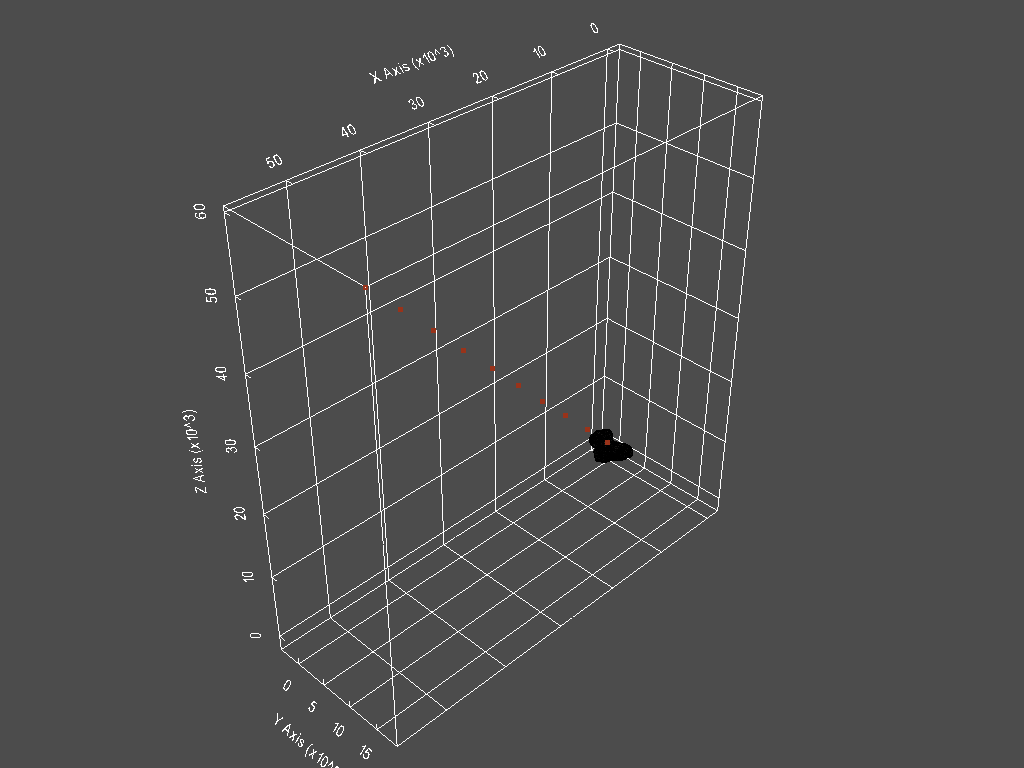

In [37]:
# Logs for output
uda = algo.extract(pg.de)
uda.get_log() 
print("Champion fitness value: ", pop.champion_f) 
print("Champion chromosome: ", pop.champion_x) 

# Retrieving champion chromosome
x = pop.champion_x

# Computing optimized trajectory
mesh, vertices, faces = mesh_utility.create_mesh()
r_store, v_store = get_trajectory(mesh, vertices, faces, x)

# Plotting trajectory
plot_trajectory(mesh, vertices, faces, r_store)